In [1]:
zip_file = 'C:/path/to/your/processed_celeba_small.zip'


In [2]:
import os
print(os.listdir())  # Lists all files in the current directory


['.git', '.ipynb_checkpoints', '2nd.ipynb', 'dlnd_face_generation.html', 'dlnd_face_generation.ipynb', 'LICENSE', 'problem_unittests.py', 'processed-celeba-small.zip', 'processed_celeba_small', 'README.md', 'train_samples.pkl', '__MACOSX', '__pycache__']


In [3]:
import zipfile
import os

# Path to your zip file
zip_file = 'processed-celeba-small.zip'

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()  # Extracts to the current directory

# Comment this line as it's not needed anymore
# !unzip processed_celeba_small.zip


In [3]:
!pip install torch


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
data_dir = 'processed_celeba_small/celeba/'

'T MODIFY ANYTHING IN THIS CELL

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

In [7]:
!pip install torchvision


Defaulting to user installation because normal site-packages is not writeable


In [8]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/celeba/'):
    

    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    data= datasets.ImageFolder(data_dir,transform=transform)
    dataloader=torch.utils.data.DataLoader(data,batch_size=batch_size, shuffle=True)
    # TODO: Implement function and return a dataloader
    
    return dataloader


In [ ]:
# Define function hyperparameters
batch_size = 20
img_size = 128


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


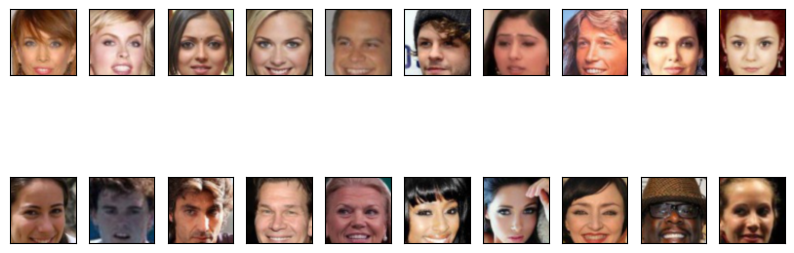

In [ ]:
## helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = next(dataiter)  # Use next() function in Python 3

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size / 2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [ ]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)


print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


In [27]:
import torch.nn as nn
import torch.nn.functional as F

In [28]:
def conv(in_channels,out_channels,kernel_size, stride=2,padding=1,batch_norm=True):
    layers=[]
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  
    layers = []
    
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        
        super(Discriminator, self).__init__()
        
        self.conv_dim=conv_dim
        
        self.conv1 = conv(3,conv_dim,4,batch_norm=False) #16*16
        
        self.conv2 = conv(conv_dim,conv_dim*2,4) #8*8
        
        self.conv3 = conv(conv_dim*2,conv_dim*4,4) #4*4
         
        self.fc1 = nn.Linear(conv_dim*4*4*4,1)
        
        
        

    def forward(self, x):
      
        x = F.leaky_relu(self.conv1(x),0.2)
        
        x = F.leaky_relu(self.conv2(x),0.2)
        
        x = F.leaky_relu(self.conv3(x),0.2)
        
        x = x.view(-1,self.conv_dim*4*4*4)
        
        x = self.fc1(x)
        
        return x



tests.test_discriminator(Discriminator)

Tests Passed


In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        
        super(Generator, self).__init__()
        
        self.conv_dim=conv_dim
        
        self.fc1 = nn.Linear(z_size,conv_dim*4*4*4)
        
        self.deconv1 = deconv(conv_dim*4,conv_dim*2,4) 
        
        self.deconv2 = deconv(conv_dim*2, conv_dim , 4)
        
        self.deconv3 = deconv(conv_dim,3, 4)
        

    def forward(self, x):     
        x = self.fc1(x)
        
        x = x.view(-1,self.conv_dim*4,4,4)
        
        x = F.leaky_relu(self.deconv1(x))
        
        x = F.leaky_relu(self.deconv2(x))
        
        x = self.deconv3(x)
        
        x = F.tanh(x)
        
        return x
    
tests.test_generator(Generator)

Tests Passed


In [ ]:
def weights_init_normal(m):
    
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv')!=-1 or classname.find('Linear')!=-1):
        mean=0.0
        sd=0.02
        nn.init.normal_(m.weight.data, mean, sd)
    

In [ ]:

def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [ ]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 130

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=130, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [ ]:

import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


In [ ]:
def real_loss(D_out):
    
    loss = torch.mean((D_out-0.9)**2)
    return loss

def fake_loss(D_out):
    
    loss = torch.mean((D_out)**2)
    return loss

In [ ]:
import torch.optim as optim

lr= 0.0001
beta1=0.1
beta2=0.99
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2]) 
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [ ]:
def train(D, G, n_epochs, print_every=5):
    
    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
                
            # ===============================================
            #              Discriminator
            # ===============================================

            d_optimizer.zero_grad()
            
            d_real_loss = real_loss(D(real_images))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))

            z = torch.from_numpy(z).float()
          
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            d_fake_loss = fake_loss(D_fake)
        
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            
            d_optimizer.step()
            
            # ===============================================
            #              Generator
            # ===============================================
      
            g_optimizer.zero_grad()
        
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
        
            D_fake = D(fake_images)
        
            g_loss = real_loss(D_fake) 
        
            g_loss.backward()
            
            g_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('pickle.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 10



# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 2.0067 | g_loss: 38.6455
Epoch [    1/  100] | d_loss: 6.4159 | g_loss: 19.4272
Epoch [    1/  100] | d_loss: 8.1150 | g_loss: 2.6766
Epoch [    1/  100] | d_loss: 4.0618 | g_loss: 2.1946
Epoch [    1/  100] | d_loss: 2.4350 | g_loss: 21.6774
Epoch [    1/  100] | d_loss: 2.7900 | g_loss: 11.4240
Epoch [    1/  100] | d_loss: 45.5009 | g_loss: 169.2678
Epoch [    1/  100] | d_loss: 4.7245 | g_loss: 29.7908
Epoch [    1/  100] | d_loss: 3.4903 | g_loss: 2.4072
Epoch [    1/  100] | d_loss: 1.8187 | g_loss: 5.0951
Epoch [    1/  100] | d_loss: 2.4318 | g_loss: 15.5127
Epoch [    1/  100] | d_loss: 7.6858 | g_loss: 41.7701
Epoch [    1/  100] | d_loss: 1.2430 | g_loss: 7.0229
Epoch [    1/  100] | d_loss: 0.7849 | g_loss: 1.0690
Epoch [    1/  100] | d_loss: 0.6207 | g_loss: 2.8370
Epoch [    1/  100] | d_loss: 1.1163 | g_loss: 11.9896
Epoch [    1/  100] | d_loss: 0.3468 | g_loss: 2.7366
Epoch [    1/  100] | d_loss: 0.9470 | g_loss: 0.3176
Epoch [    1/  10

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [ ]:
def view_random_sample(generator, z_size):
    # Generate a new random latent vector for each sample
    z = torch.randn(1, z_size).cuda() if train_on_gpu else torch.randn(1, z_size)
    
    # Put the generator in evaluation mode
    generator.eval()
    with torch.no_grad():
        img = generator(z).detach().cpu().numpy()[0]
    
    # Process and display the image
    img = np.transpose(img, (1, 2, 0))  # Transpose the dimensions for display
    img = ((img + 1) * 255 / 2).astype(np.uint8)  # Normalize to 0-255 and convert to uint8
    
    # Plot the image
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.axis('off')
    plt.show()




In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
#_ = view_single_sample(-1, samples)
# Generate a new sample each time this function is called
view_random_sample(G, z_size)